In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ngocphule
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification


{"username":"ngocphule","key":"3ddbfd875e3106a4fcf8de24cc8983ce"}

## Импорт библиотек

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

## Загрузка категорий изображений

In [ ]:
BASE_DIR = 'vehicle-classification/Vehicles'
categories = os.listdir(BASE_DIR)
categories

['Bikes', 'Trains', 'Planes', 'Ships', 'Motorcycles', 'Cars', 'Auto Rickshaws']

In [ ]:
for category in categories:
  fnames = os.listdir(os.path.join(BASE_DIR, category))
  print(f'5 files in {category} subdir: {fnames[:5]}')

5 files in Bikes subdir: ['Bike (446).jpg', 'Bike (773).jpg', 'Bike (89).jpg', 'Bike (112).jpg', 'Bike (230).jpg']
5 files in Trains subdir: ['Train (210).png', 'Train (756).jpg', 'Train (264).jpg', 'Train (568).jpg', 'Train (323).jpg']
5 files in Planes subdir: ['Plane (711).jpg', 'Plane (95).jpg', 'Plane (382).jpg', 'Plane (486).jpg', 'Plane (406).jpg']
5 files in Ships subdir: ['Ship (704).jpg', 'Ship (287).jpg', 'Ship (417).jpg', 'Ship (294).jpg', 'Ship (136).jpg']
5 files in Motorcycles subdir: ['Motorcycle (61).jpg', 'Motorcycle (602).jpg', 'Motorcycle (133).jpg', 'Motorcycle (121).jpg', 'Motorcycle (118).jpg']
5 files in Cars subdir: ['Car (381).jpg', 'Car (543).jpg', 'Car (607).jpg', 'Car (389).jpg', 'Car (526).jpg']
5 files in Auto Rickshaws subdir: ['Auto Rickshaw (378).jpg', 'Auto Rickshaw (237).jpg', 'Auto Rickshaw (778).jpg', 'Auto Rickshaw (617).jpg', 'Auto Rickshaw (417).PNG']


## Подсчёт количества изображений в каждой категории

Подсчитываем общее количество изображений в каждой папке.
Это важно для понимания, сбалансирован ли набор данных по классам.

In [ ]:
for category in categories:
  fnames = os.listdir(os.path.join(BASE_DIR, category))
  print(f'Total {category} images: {len(fnames)}')

Total Bikes images: 800
Total Trains images: 800
Total Planes images: 800
Total Ships images: 800
Total Motorcycles images: 800
Total Cars images: 790
Total Auto Rickshaws images: 800


In [ ]:
pathlib = os.path.join(BASE_DIR, 'Cars')

## Визуализация изображений по категориям

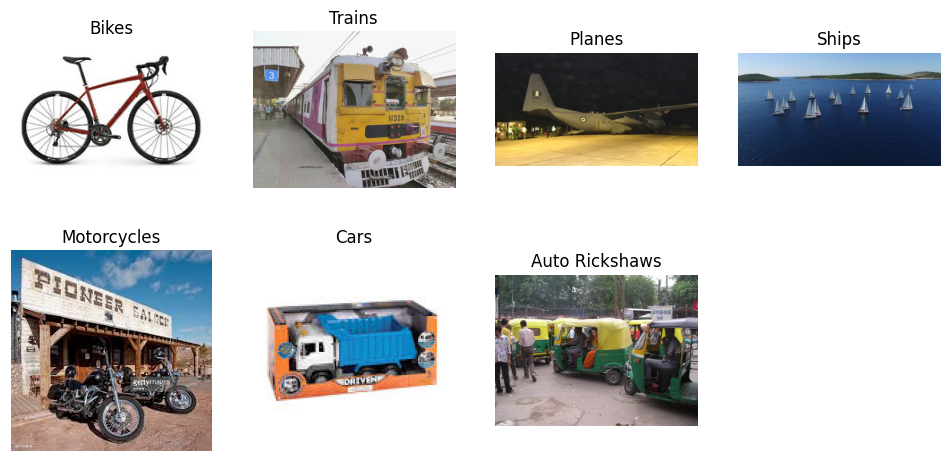

In [ ]:
plt.figure(figsize=(12, 12))
for i, category in enumerate(categories):
  fnames = os.listdir(os.path.join(BASE_DIR, category))
  first_img = fnames[3]
  img_path = os.path.join(BASE_DIR, category, first_img)
  img = Image.open(img_path)
  plt.subplot(4 , 4 , i+1)
  plt.imshow(img)
  plt.title(category)
  plt.axis('off')

## 🧹 Удаление неподдерживаемых изображений

Иногда изображения могут быть повреждены или иметь нестандартный формат.
Эта функция проверяет, можно ли открыть изображение, и удаляет те, которые невозможно декодировать с помощью TensorFlow.

In [ ]:
def is_supported_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        tf.image.decode_image(image, channels=3)
        return True
    except:
        return False

for category in categories:
  dataset_dir = os.path.join(BASE_DIR, category)
  image_paths = [os.path.join(dataset_dir, fname) for fname in os.listdir(dataset_dir)]

  for image_path in image_paths:
      if not is_supported_image(image_path):
        print(f"Unsupported format: {image_path}")
        os.remove(image_path)

Unsupported format: vehicle-classification/Vehicles/Planes/Plane (718).webp
Unsupported format: vehicle-classification/Vehicles/Planes/Plane (633).webp
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (617).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (519).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (418).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (462).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (421).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (262).png
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (151).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (649).jpg
Unsupported format: vehicle-classification/Vehicles/Auto Rickshaws/Auto Rickshaw (315).jpg
Unsupported format: vehicle-c

## Создание обучающего и валидационного датасета

Используем `image_dataset_from_directory`, чтобы автоматически создать датасеты.
- Размер изображений нормализуется до 120x120 пикселей.
- Данные делятся на обучающую и валидационную выборки (80/20).
- Метки классов кодируются в формате one-hot (categorical).

In [ ]:
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    BASE_DIR,
    image_size = (120, 120),
    batch_size = 32,
    validation_split = 0.2,
    subset = 'both',
    seed = 42,
    label_mode = 'categorical'
)

Found 5568 files belonging to 7 classes.
Using 4455 files for training.
Using 1113 files for validation.


## Аугментация данных

Чтобы улучшить способность модели обобщать, применяем аугментацию:
- Случайное отражение по горизонтали
- Повороты изображений
- Сдвиги (трансляции)
- Масштабирование

Это особенно полезно при ограниченном количестве данных.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2, fill_mode = 'nearest'),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode = 'nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode = 'nearest')
])

## Построение сверточной нейронной сети

Модель строится по архитектуре Sequential и включает:
- Слой нормализации (Rescaling), приводящий значения пикселей к диапазону [0, 1]
- Последовательность сверточных слоёв и слоёв подвыборки (MaxPooling)
- Увеличение количества фильтров на каждом уровне
- Слой Flatten для преобразования тензора в вектор
- Полносвязный слой на 512 нейронов с Dropout
- Выходной слой с функцией активации softmax для классификации по 7 классам

## ⚙️ Компиляция модели

Настраиваем модель:
- Optimizer: Adam (адаптивный градиентный метод)
- Loss: categorical_crossentropy (так как метки в one-hot)
- Metric: accuracy (точность классификации)

In [ ]:
model_clf = tf.keras.Sequential([
    tf.keras.Input(shape = (120, 120, 3)),
    data_augmentation,
    # rescaling layer
    tf.keras.layers.Rescaling(1./255),
    # Convolutional layers
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation = 'softmax')
])

In [ ]:
model_clf.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
model_clf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,669,319 (14.00 MB)

 Trainable params: 3,669,319 (14.00 MB)

 Non-trainable params: 0 (0.00 B)

## Callback для ранней остановки

Создаем пользовательский callback, который завершает обучение, если и точность, и валидационная точность превышают 80%.
Это позволяет не тратить лишние эпохи, если модель уже достигла желаемого уровня.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = None):
    if logs['accuracy'] >= 0.8 and logs['val_accuracy'] >= 0.8:
      print('Training cancelled')
      self.model.stop_training = True

## Обучение модели

Запускаем процесс обучения:
- Обучение проходит по эпохам (до 100, но может остановиться раньше благодаря callback)
- Используется обучающая и валидационная выборка
- Вывод осуществляется в режиме verbose=2 для отображения прогресса

In [ ]:
history1 = model_clf.fit(train_dataset, epochs = 100, validation_data = validation_dataset,
                        verbose = 2, callbacks = [myCallback()])

Epoch 1/100
140/140 - 32s - 232ms/step - accuracy: 0.2905 - loss: 1.7426 - val_accuracy: 0.4510 - val_loss: 1.4970
Epoch 2/100
140/140 - 38s - 269ms/step - accuracy: 0.4525 - loss: 1.4477 - val_accuracy: 0.4232 - val_loss: 1.6603
Epoch 3/100
140/140 - 40s - 286ms/step - accuracy: 0.4983 - loss: 1.3624 - val_accuracy: 0.5597 - val_loss: 1.1716
Epoch 4/100
140/140 - 30s - 217ms/step - accuracy: 0.5479 - loss: 1.2364 - val_accuracy: 0.5768 - val_loss: 1.2101
Epoch 5/100
140/140 - 26s - 188ms/step - accuracy: 0.5661 - loss: 1.1746 - val_accuracy: 0.5741 - val_loss: 1.1864
Epoch 6/100
140/140 - 41s - 290ms/step - accuracy: 0.5966 - loss: 1.1006 - val_accuracy: 0.6298 - val_loss: 0.9711
Epoch 7/100
140/140 - 40s - 286ms/step - accuracy: 0.6303 - loss: 1.0430 - val_accuracy: 0.6128 - val_loss: 1.0525
Epoch 8/100
140/140 - 42s - 301ms/step - accuracy: 0.6355 - loss: 1.0116 - val_accuracy: 0.6217 - val_loss: 1.0592
Epoch 9/100
140/140 - 40s - 284ms/step - accuracy: 0.6572 - loss: 0.9414 - val_a

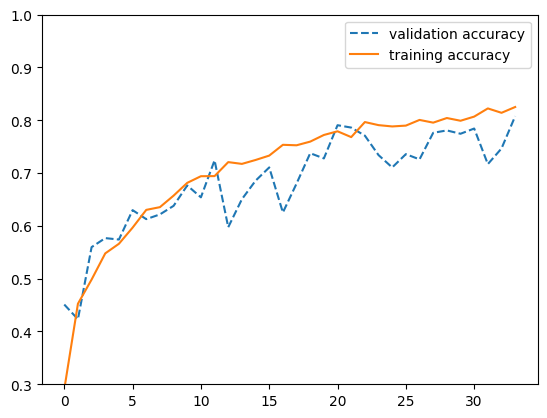

In [ ]:
def plot_training_curve(history):
  epochs = np.arange(len(history.history['val_accuracy']))
  plt.plot(epochs, history.history['val_accuracy'], label = 'validation accuracy', linestyle = '--')
  plt.plot(epochs, history.history['accuracy'], label = 'training accuracy')
  plt.legend()
  plt.ylim([0.3, 1.0])
  plt.show()

plot_training_curve(history1)

## Матрица ошибок и отчёт классификации

Используем confusion matrix для оценки, как часто модель путает классы между собой.
Также выводим `classification_report`, включающий precision, recall и F1-score для каждой категории.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


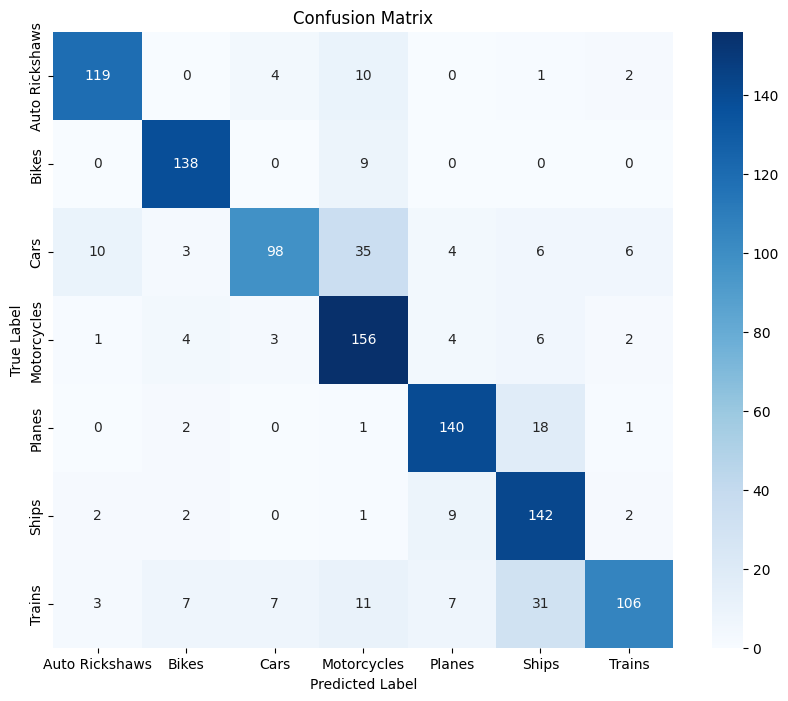

                precision    recall  f1-score   support

Auto Rickshaws       0.88      0.88      0.88       136
         Bikes       0.88      0.94      0.91       147
          Cars       0.88      0.60      0.72       162
   Motorcycles       0.70      0.89      0.78       176
        Planes       0.85      0.86      0.86       162
         Ships       0.70      0.90      0.78       158
        Trains       0.89      0.62      0.73       172

      accuracy                           0.81      1113
     macro avg       0.83      0.81      0.81      1113
  weighted avg       0.82      0.81      0.80      1113



In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Conver validation_dataset to arrays
y_true = []
y_pred = []

class_names = train_dataset.class_names  # Get class name

for images, labels in validation_dataset:
    preds = model_clf.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Báo cáo chi tiết
print(classification_report(y_true, y_pred, target_names=class_names))


## Примеры неверной классификации

Отображаем изображения, которые были классифицированы неправильно.
Для каждого показано:
- Истинная метка
- Предсказанная метка

Это помогает выявить сложные случаи или потенциальные проблемы в данных.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


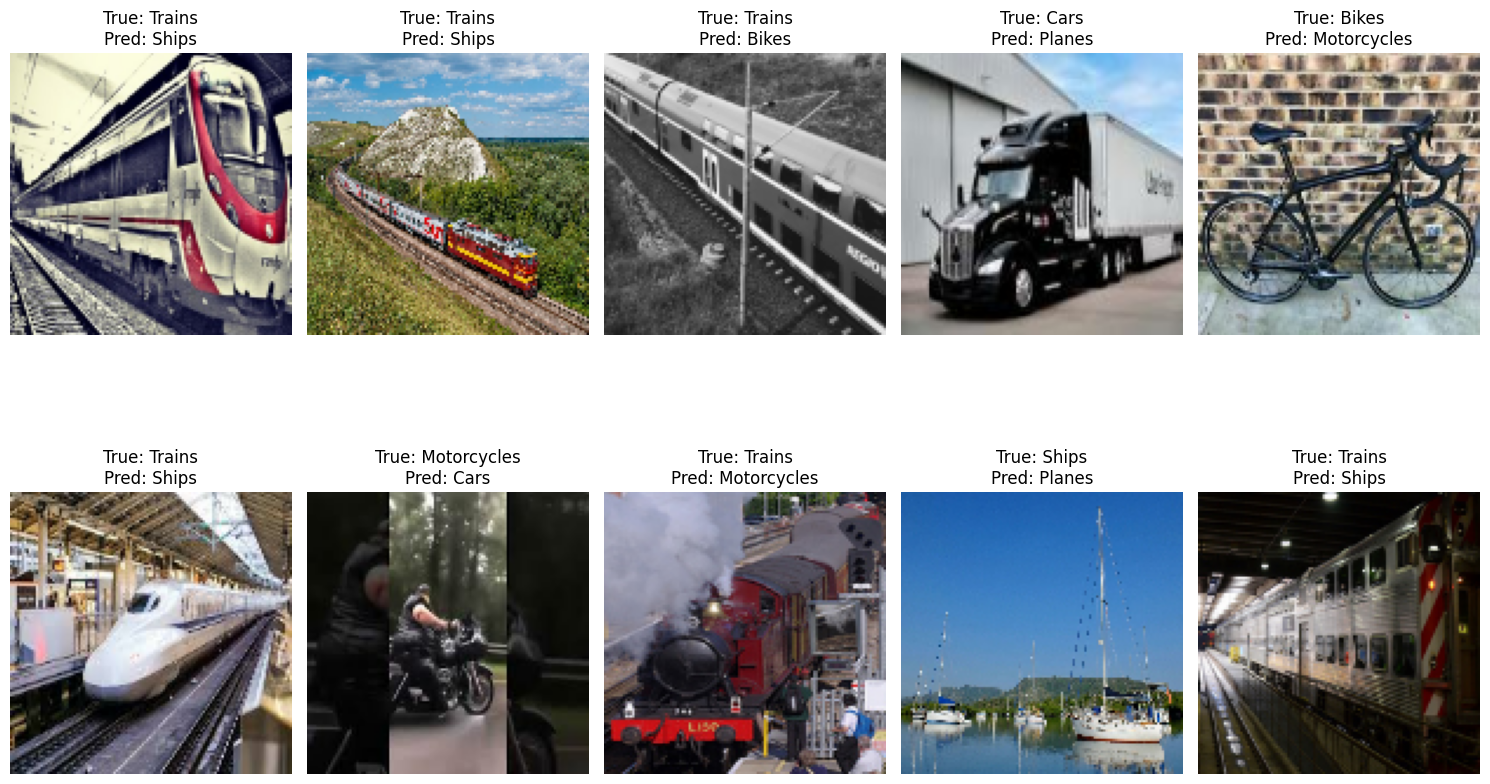

In [ ]:
# Hiển thị 10 ảnh bị phân loại sai
num_errors_to_show = 10
error_count = 0

plt.figure(figsize=(15, 10))

for images, labels in validation_dataset:
    preds = model_clf.predict(images)
    for i in range(len(images)):
        true_label = np.argmax(labels[i].numpy())
        predicted_label = np.argmax(preds[i])
        if true_label != predicted_label:
            error_count += 1
            plt.subplot(2, 5, error_count)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
            plt.axis('off')
            if error_count >= num_errors_to_show:
                break
    if error_count >= num_errors_to_show:
        break

plt.tight_layout()
plt.show()
